## FNDAhw08
from sklearn.tree import DecisionTreeClassifier  
用上述的DecisionTreeClassifier构建决策树模型，对下述4个变量进行调优：  
* max_depth  
* min_samples_split  
* min_samples_leaf  
* max_features

比较决策树和随机森林模型的准确度（用代码中的ROC_AUC的结果衡量，越高越好）


In [1]:
# %load Random Forest.py
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn import metrics,cross_validation
from matplotlib import pyplot as plt

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
def Missingrate_Column(df, col):
    '''
    :param df:
    :param col:
    :return:
    '''
    missing_records = df[col].map(lambda x: int(x!=x))
    return missing_records.mean()


def Makeup_Missing(df,col, makeup_value):
    '''
    :param df:
    :param col:
    :return:
    '''
    raw_values = list(df[col])
    missing_position = [i for i in range(len(raw_values)) if raw_values[i] != raw_values[i]]
    for i in missing_position:
        raw_values[i] = makeup_value
    return raw_values



def Avg_Calc(numerator, denominator):
    if denominator == 0:
        return 0
    else:
        return numerator/denominator

def ROC_AUC(df, score, target, plot=True):
    df2 = df.copy()
    s = list(set(df2[score]))
    s.sort()
    tpr_list = [0]
    fpr_list = [0]
    for k in s:
        df2['label_temp'] = df[score].map(lambda x: int(x >= k))
        TP = df2[(df2.label_temp==1) & (df2[target]==1)].shape[0]
        FN = df2[(df2.label_temp == 1) & (df2[target] == 0)].shape[0]
        FP = df2[(df2.label_temp == 0) & (df2[target] == 1)].shape[0]
        TN = df2[(df2.label_temp == 0) & (df2[target] == 0)].shape[0]
        try:
            TPR = TP / (TP + FN)
        except:
            TPR =0
        try:
            FPR = FP / (FP + TN)
        except:
            FPR = 0
        tpr_list.append(TPR)
        fpr_list.append(FPR)
    tpr_list.append(1)
    fpr_list.append(1)
    ROC_df = pd.DataFrame({'tpr': tpr_list, 'fpr': fpr_list})
    ROC_df = ROC_df.sort_values(by='tpr')
    ROC_df = ROC_df.drop_duplicates()
    auc = 0
    ROC_mat = np.mat(ROC_df)
    for i in range(1, ROC_mat.shape[0]):
        auc = auc + (ROC_mat[i, 1] + ROC_mat[i - 1, 1]) * (ROC_mat[i, 0] - ROC_mat[i - 1, 0]) * 0.5
    if plot:
        plt.plot(ROC_df['fpr'], ROC_df['tpr'])
        plt.plot([0, 1], [0, 1])
        plt.title("AUC={}%".format(int(auc * 100)))
    return auc


def KS(df, score, target, plot = True):
    '''
    :param df: 包含目标变量与预测值的数据集
    :param score: 得分或者概率
    :param target: 目标变量
    :return: KS值
    :return: KS值
    '''
    total = df.groupby([score])[target].count()
    bad = df.groupby([score])[target].sum()
    all = pd.DataFrame({'total':total, 'bad':bad})
    all['good'] = all['total'] - all['bad']
    all[score] = all.index
    all = all.sort_values(by=score, ascending = False)
    all.index = range(len(all))
    all['badCumRate'] = all['bad'].cumsum() / all['bad'].sum()
    all['goodCumRate'] = all['good'].cumsum() / all['good'].sum()
    KS_list = all.apply(lambda x: x.badCumRate - x.goodCumRate, axis=1)
    KS = max(KS_list)
    if plot:
        plt.plot(list(all.index), all['badCumRate'])
        plt.plot(list(all.index), all['goodCumRate'])
        plt.title('KS ={}%'.format(int(KS*100)))
    return KS

In [5]:
#######################
####  1，读取数据  #####
#######################
# folderOfData = '/Users/Code/Data Collections/AF/'
data = pd.read_csv('../05/anti_fraud_data.csv', header = 0)
del data['ID']
data.head(1)

,is_email_acct,certificationtype,registered_channels,sex,age,registered_days,area1_danger,area4_danger,is_area3_eqaul_area4,is_area3_equal_area6,...,10m_pay_times,12h_pay_times,1d_pay_times,1h_pay_times,30m_pay_times,10m_Sum_pay_amount,12h_Sum_pay_amount,1d_Sum_pay_amount,1h_Sum_pay_amount,flag
0,0.0,2,SDK,1.0,42,219,5.0,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0


In [6]:
data.shape

(46978, 95)

In [7]:
#为了减少训练时间，减少数据集
data = data.iloc[:10000,:]

In [9]:
train_data, test_data = train_test_split(data, test_size=0.3)

#########################
####  2，数据预处理  #####
#########################

all_columns = list(train_data.columns)
all_columns.remove('flag')
all_columns

['is_email_acct',
 'certificationtype',
 'registered_channels',
 'sex',
 'age',
 'registered_days',
 'area1_danger',
 'area4_danger',
 'is_area3_eqaul_area4',
 'is_area3_equal_area6',
 'is_area4_equal_area6',
 'is_area5_equal_area3',
 'is_area5_equal_area4',
 'is_area5_equal_area6',
 'is_area1_equal_area2',
 'is_area7_equal_area3',
 'is_area7_equal_area4',
 'is_area7_equal_area6',
 'is_area7_equal_area5',
 'is_area2_equal_area3',
 'is_area2_equal_area4',
 'is_area2_equal_area6',
 'is_area2_equal_area5',
 'area4_danger.1',
 'area2_danger',
 'area10_danger',
 'ip_desc_danger',
 'is_area1_equal_area11',
 'is_area10_equal_area8',
 'is_area10_equal_area9',
 'is_area2_equal_area8',
 'is_area2_equal_area9',
 'is_area8_equal_area3',
 'is_area8_equal_area4',
 'is_area8_equal_area6',
 'is_area8_equal_area5',
 'is_area8_equal_area9',
 'is_area9_equal_area3',
 'is_area9_equal_area4',
 'is_area9_equal_area6',
 'is_area9_equal_area5',
 'area8_danger',
 'area11_danger',
 'area6_danger',
 'paytime_hou

In [10]:
#查看每个字段的缺失率
column_missingrate = {col: Missingrate_Column(train_data, col) for col in all_columns}
column_MR_df = pd.DataFrame.from_dict(column_missingrate, orient='index')
column_MR_df.columns = ['missing_rate']
column_MR_df_sorted = column_MR_df.sort_values(by='missing_rate', ascending=False)
#由于变量ip_desc_danger在训练集中全部缺失，故将其删去。
all_columns.remove('ip_desc_danger')
del train_data['ip_desc_danger']
column_MR_df_sorted = column_MR_df_sorted.drop(index=['ip_desc_danger'])
columns_with_missing = column_MR_df_sorted[column_MR_df_sorted.missing_rate > 0].index


categorical_cols_withmissing = ['area1_danger','registered_channels','sex','is_email_acct','area8_danger','area6_danger','area11_danger']
dummy_map = {}
dummy_columns = []
for raw_col in categorical_cols_withmissing:
    dummies = pd.get_dummies(train_data.loc[:, raw_col], prefix=raw_col)
    col_onehot = pd.concat([train_data[raw_col], dummies], axis=1)
    col_onehot = col_onehot.drop_duplicates()
    train_data = pd.concat([train_data, dummies], axis=1)
    del train_data[raw_col]
    dummy_map[raw_col] = col_onehot
    dummy_columns = dummy_columns + list(dummies)

#对于数值型变量，可以将原始变量与表示缺失状态的示性变量交互地使用.此外，由于这些变量都是非负数，对于缺失，可以用0来填补
continuous_cols_withmissing = [i for i in columns_with_missing if i not in categorical_cols_withmissing]
for col in continuous_cols_withmissing:
    train_data[col+'_ismissing']  = train_data[col].map(lambda x: int(x!=x))
    train_data[col] = Makeup_Missing(train_data, col, 0)

#注意到，原始数据中，年龄age没有缺失值，但是有0.需要将0看成缺失
train_data['age'+'_ismissing']  = train_data['age'].map(lambda x: int(x==0))

In [11]:
#######################
####  3，特征衍生  #####
#######################
#（1）构造平均值型变量
periods = ['10m','30m','1h','12h','1d','7d','15d','30d','60d','90d']
for period in periods:
    amount = period+'_Sum_pay_amount'
    times = period+'_pay_times'
    avg_payment = period+'_Avg_pay_amount'
    train_data[avg_payment] = train_data[[amount,times]].apply(lambda x: Avg_Calc(x[amount],x[times]),axis=1)

#（2）构造变量，检查平均每次支付金额上升量
for i in range(len(periods)-1):
    avg_payment_1 = periods[i]+'_Avg_pay_amount'
    avg_payment_2 = periods[i+1] + '_Avg_pay_amount'
    increase_payment = periods[i] + '_' + periods[i+1] + '_payment_increase'
    train_data[increase_payment] = train_data[[avg_payment_1,avg_payment_2]].apply(lambda x: x[avg_payment_1] - x[avg_payment_2],axis=1)


#（3）在（1）的基础上求最大的平均支付金额值
avg_payments = [d+'_Avg_pay_amount' for d in periods]
train_data['max_Avg_pay_amount'] = train_data[avg_payments].apply(lambda x: max(x),axis=1)
features = list(train_data.columns)
features.remove('flag')
X,y = train_data[features], train_data['flag']

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.9875714285714285


0.9999908638948739

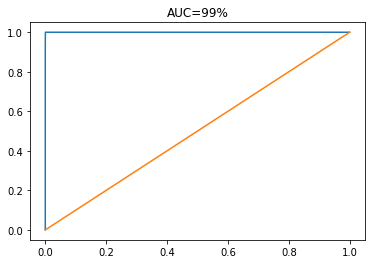

In [12]:
##########################
####  4，构建随机森林  #####
##########################
#使用默认参数进行建模
RFC = RandomForestClassifier(oob_score=True)
RFC.fit(X,y)
#袋外数据准确率
print(RFC.oob_score_)
y_predprob = RFC.predict_proba(X)[:,1]
result = pd.DataFrame({'real':y,'pred':y_predprob})
#print("AUC Score (Train): %f" % metrics.roc_auc_score(y, y_predprob))
ROC_AUC(result, 'pred', 'real')

In [13]:
#参数调整
#1，调整n_estimators
param_test1 = {'n_estimators':range(10,101,10)}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(),param_grid = param_test1, scoring='roc_auc',cv=5)
gsearch1.fit(X,y)
best_n_estimators_1 = gsearch1.best_params_['n_estimators']  #80
best_n_estimators_1

100

In [14]:
param_test1 = {'n_estimators':range(71,89)}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(),param_grid = param_test1, scoring='roc_auc',cv=5)
gsearch1.fit(X,y)
best_n_estimators = gsearch1.best_params_['n_estimators']  #84
best_n_estimators

80

In [15]:
#2，对决策树最大深度max_depth,内部节点再划分所需最小样本数min_samples_split和叶子节点最少样本数min_samples_leaf进行网格搜索
param_test2 = {'max_depth':range(5,15), 'min_samples_split':range(20,81,10), 'min_samples_leaf':range(5,21,5)}
gsearch2 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= best_n_estimators),param_grid = param_test2, scoring='roc_auc',cv=5)
gsearch2.fit(X,y)
best_max_depth, best_min_samples_split, best_min_samples_leaf = gsearch2.best_params_['max_depth'],gsearch2.best_params_['min_samples_leaf'],gsearch2.best_params_['min_samples_split']
best_max_depth, best_min_samples_split, best_min_samples_leaf

(13, 5, 20)

0.9872857142857143


0.9930328937378701

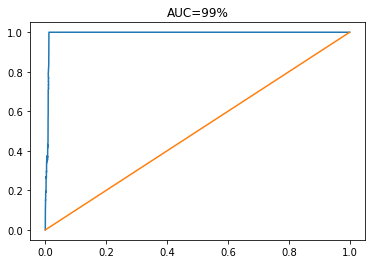

In [19]:
#3，对max_features进行调优
param_test3 ={'max_features':['sqrt','log2']}
gsearch3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= best_n_estimators,
                                                           max_depth = best_max_depth,
                                                           min_samples_split = best_min_samples_split,
                                                           min_samples_leaf = best_min_samples_leaf),
                        param_grid = param_test3, scoring='roc_auc',cv=5)
gsearch3.fit(X,y)
best_max_features = gsearch3.best_params_['max_features']

RFC_2 = RandomForestClassifier(oob_score=True, n_estimators= best_n_estimators,
                            max_depth = best_max_depth,min_samples_split = best_min_samples_split,
                            min_samples_leaf = best_min_samples_leaf,max_features = best_max_features)
RFC_2.fit(X,y)
print(RFC_2.oob_score_)
y_predprob = RFC_2.predict_proba(X)[:,1]
result = pd.DataFrame({'real':y,'pred':y_predprob})
#print("AUC Score (Train): %f" % metrics.roc_auc_score(y, y_predprob))
ROC_AUC(result, 'pred', 'real')

Text(0.5,1,'feature importance')

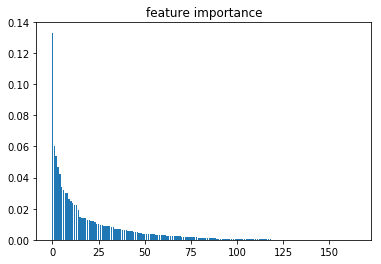

In [20]:
#特征重要性评估
fi = RFC_2.feature_importances_
fi = sorted(fi, reverse=True)
plt.bar(list(range(len(fi))), fi)
plt.title('feature importance')

In [21]:
###############################
####  5，在测试集上进行测试  #####
###############################
#准备测试样本#
del test_data['ip_desc_danger']
#在对测试集进行哑变量编码或者独热编码的时候，要按照在训练集中的编码方式来进行
#例如，在训练集中，设备类型={Android， Apple， SDK}，但是在测试集中设备类型={Android， Apple， SDK， PC}。多出来的值在编码中全部为0
train_data, test_data = train_test_split(data, test_size=0.3)
test_data_cp = test_data.copy()

for raw_col in categorical_cols_withmissing:
    test_data = pd.merge(test_data, dummy_map[raw_col],on =raw_col, how='left')
    del test_data[raw_col]
dummy_columns = test_data[dummy_columns]
dummy_columns.isnull().any()

area1_danger_5.0               False
registered_channels_31         False
registered_channels_ANDROID    False
registered_channels_APP        False
registered_channels_IOS        False
registered_channels_PC         False
registered_channels_SDK        False
registered_channels_WAP        False
sex_1.0                        False
sex_2.0                        False
is_email_acct_0.0              False
is_email_acct_1.0              False
area8_danger_1.0               False
area8_danger_2.0               False
area8_danger_3.0               False
area8_danger_4.0               False
area8_danger_5.0               False
area6_danger_1                 False
area6_danger_2                 False
area6_danger_3                 False
area6_danger_4                 False
area6_danger_5                 False
area6_danger_other             False
area11_danger_1                False
area11_danger_2                False
area11_danger_3                False
area11_danger_4                False
a

0.9986385678209382

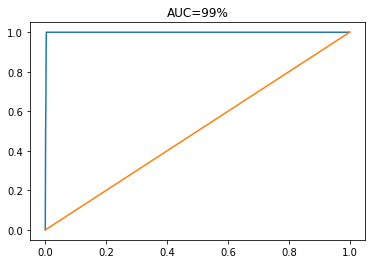

In [22]:
for col in continuous_cols_withmissing:
    test_data[col+'_ismissing']  = test_data[col].map(lambda x: int(x!=x))
    test_data[col] = Makeup_Missing(test_data, col, 0)

#注意到，原始数据中，年龄age没有缺失值，但是有0.需要将0看成缺失
test_data['age'+'_ismissing']  = test_data['age'].map(lambda x: int(x==0))
for period in periods:
    amount = period+'_Sum_pay_amount'
    times = period+'_pay_times'
    avg_payment = period+'_Avg_pay_amount'
    test_data[avg_payment] = test_data[[amount,times]].apply(lambda x: Avg_Calc(x[amount],x[times]),axis=1)

#（2）构造变量，检查平均每次支付金额上升量
for i in range(len(periods)-1):
    avg_payment_1 = periods[i]+'_Avg_pay_amount'
    avg_payment_2 = periods[i+1] + '_Avg_pay_amount'
    increase_payment = periods[i] + '_' + periods[i+1] + '_payment_increase'
    test_data[increase_payment] = test_data[[avg_payment_1,avg_payment_2]].apply(lambda x: x[avg_payment_1] - x[avg_payment_2],axis=1)


#（3）在（1）的基础上求最大的平均支付金额值
avg_payments = [d+'_Avg_pay_amount' for d in periods]
test_data['max_Avg_pay_amount'] = test_data[avg_payments].apply(lambda x: max(x),axis=1)

# 用默认参数的随机森林进行建模
X_test,y_test = test_data[features], test_data['flag']
y_predprob = RFC.predict_proba(X_test)[:,1]
result = pd.DataFrame({'real':y_test,'pred':y_predprob})
ROC_AUC(result, 'pred', 'real')

0.9935556211396905

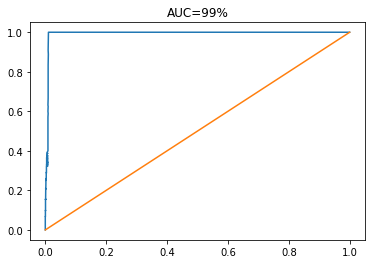

In [23]:
# 用调优后的随机森林进行建模
y_predprob2 = RFC_2.predict_proba(X_test)[:,1]
result = pd.DataFrame({'real':y_test,'pred':y_predprob2})
ROC_AUC(result, 'pred', 'real')

0.8822097444827464

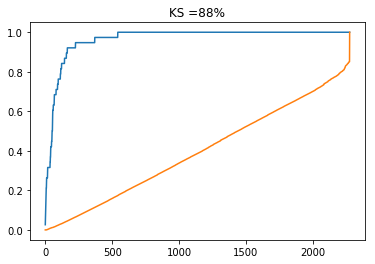

In [24]:
KS(result, 'pred', 'real')

In [25]:
from sklearn.tree import DecisionTreeClassifier

In [26]:
model = DecisionTreeClassifier()
model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

1.0

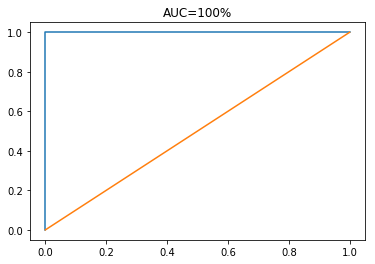

In [32]:
y_predprob = model.predict_proba(X)[:,1]
result = pd.DataFrame({'real':y,'pred':y_predprob})
ROC_AUC(result, 'pred', 'real')